### Small Adversarial demonstration
* This example is adapted from the Stanford convolutional network course. 
* Ref: Szegedy et al, "Intriguing properties of neural networks", ICLR 2014



##### Basic idea

In [13]:
import numpy as np
import pandas as pd
import os
import glob
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

eps = np.finfo(float).eps

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

# All Stanford utility and helper functions
import cs_utils as cs

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline
%load_ext autoreload

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load pretrained model

In [8]:
# Download and load the pretrained SqueezeNet model. Build in using torchvision. 
# Squeezenet is small enough for the CPU. It will download automatically.

model = torchvision.models.squeezenet1_1(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

/Users/Maurits/Development/virtual_env/ML/lib/python3.6/site-packages/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
/Users/Maurits/Development/virtual_env/ML/lib/python3.6/site-packages/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth" to /Users/Maurits/.torch/models/squeezenet1_1-f364aa15.pth
100%|██████████| 4966400/4966400 [00:00<00:00, 40435187.87it/s]


### Load imagenet
* I put the npz file on gallager in /data/ML/
* there is also a .sh download script

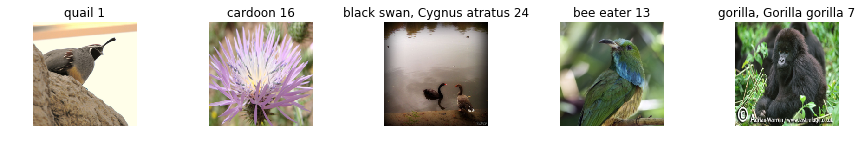

In [10]:
# This is my mac!
file_path = 'data/imagenet_val_25.npz'

X, y, class_names = cs.load_imagenet_val(file_path, num=25)
draw = np.random.choice(25, 5)

plt.figure(figsize=(12, 6))
k = 0
for i in draw:
    plt.subplot(1, 5, k + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]] + ' ' + str(i))
    plt.axis('off')
    k += 1
plt.gcf().tight_layout()

In [11]:
# Images are (N, H, W, C) 
# After tensor conversion they will be (N, C, H, W)
X.shape

(25, 224, 224, 3)

### Build Saliency / gradient maps
* So, gradients wrt the image, or dx

In [38]:
def gradient_map(X, y, model):
    
    # Eval, no learning with updating gradients
    model.eval()
    
    # Define loss function here. This demo will aim the alter an image such that squeezenet
    # miss classifies it, so it is run-of-the-mill cross entropy against the labels
    loss_fn = nn.CrossEntropyLoss()
    
    # Take X as the batch, forward pass
    scores = model(X)
    
    # Loss against ground truth labels
    loss = loss_fn(scores, y)
    
    # backward pass to collect gradients. These are set in the nodes/tensors of our model. 
    # Also because to determine symbolic gradients you need cached 
    # information from the forward pass.
    
    loss.backward()
    
    # Read out gradients from X tensor
    # X = (N, C, H, W), with N the batchsize and C the channels. We sum over the channels.
    gradient_map = X.grad.data.sum(1).abs()
    
    return gradient_map

### Read and process image data
* Mean and std normalization, this parameters for imagenet are given and hardcoded
* Rescale to network size (224)
* To tensor

In [39]:
# Convert X and y from numpy arrays to Torch Tensors. Again this is just one batch of images
X_tensor = torch.cat([cs.preprocess(Image.fromarray(x)) for x in X], dim=0)

# Model parameters are frozen, but we do need a gradient on X
X_tensor.requires_grad = True

y_tensor = torch.LongTensor(y)

In [45]:
# Compute the gradient map.
grad_images = gradient_map(X_tensor, y_tensor, model)

In [46]:
grad_images.size()

torch.Size([25, 224, 224])

In [47]:
# Tensor to numpy
grad_images = grad_images.data.numpy()

In [48]:
type(grad_images)

numpy.ndarray

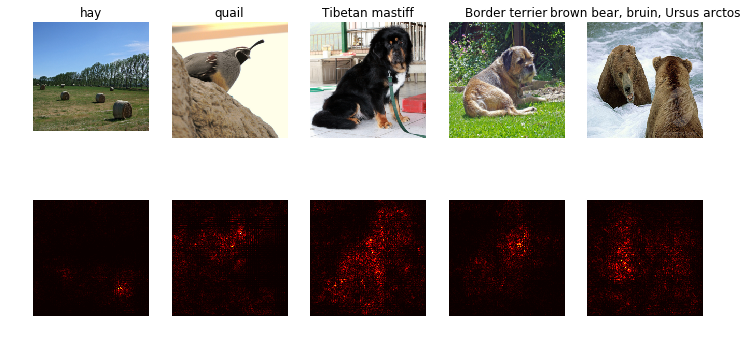

In [58]:
# Show them
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots

N = 5

plt.figure(figsize=(12, 6))
for i in range(N):
    plt.subplot(2, N, i + 1)
    plt.imshow(X[i])
    plt.axis('off')
    plt.title(class_names[y[i]])
    plt.subplot(2, N, N + i + 1)
    plt.imshow(grad_images[i], cmap=plt.cm.hot)
    plt.axis('off')
#     plt.gcf().set_size_inches(12, 5)
plt.show()

### Make the adversarial image
The goal is to minimally modify an image, such that it gets targeted as a different class. So, given an image and a target_class we perform a *gradient ascent* loop where we alter the image, based on the gradients until the network classifies it as target_class

In [133]:
def make_adv_image(X, target_y, model):
    """
    Generate a adversarial image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_adv: An image that is close to X, but that is classifed as target_y
    by the model.
    """
        
    # This is the tensor, which will hold the gradients and image data. The
    # advarsarial image starts as a copy of the original image. 
    # It could also just be a random noise realization
    X_adv_tensor = X.clone()
    X_adv_tensor.requires_grad = True

    lr = 1
    
    # no updates or learning in the model
    model.eval()
    
    while True:
        # Forward pass. 
        scores = model(X_adv_tensor)    
        # Get class predictions over 1000 classes
        pred_ind = scores.data.max(dim=1)[1][0]
        # Now we want this image to be classified as target_y
        if pred_ind != target_y:
            
            # Magic, backprop from intended or targeted 'correct' label. Not from
            # cross entropy loss. This is done because target_y is just a class label.
            # Not a hot encoded [1000, 1] training label
            scores[:, target_y].backward()
            
            # Get image tensor gradients
            g = X_adv_tensor.grad.data
            
            # Gradient ascent update rule. Note that here we don't inforce that the 
            # adv image actually looks like the original image.  This could be added as extra
            # condition. But we do only add tiny tiny amounts of data, so the result is ok.
            dX = lr * g / torch.norm(g, 2)
            
            # Add to adversarial image
            X_adv_tensor.data = torch.add(X_adv_tensor.data, dX)
            
            # Zero out the gradients on adv tensor, for the next round. You don't want
            # to accumulate them as you would normally do WITHIN the mini-batch.
            X_adv_tensor.grad.data.zero_()
            
        else:
            break
            
    return X_adv_tensor 

In [134]:
idx = 0
target_y = 6

X_tensor = torch.cat([cs.preprocess(Image.fromarray(x)) for x in X], dim=0)
# X_tensor.requires_grad = True
X_adv = make_adv_image(X_tensor[idx:idx+1], target_y, model)

# Unit test to see if the made adversarial example indeed misclassifies
scores = model(X_adv)
assert target_y == scores.data.max(1)[1][0], 'The model is not fooled!'

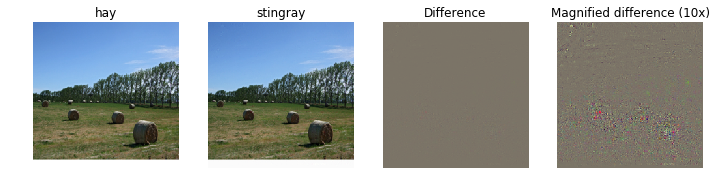

In [105]:
X_adv_np = cs.deprocess(X_adv.clone())
X_adv_np = np.asarray(X_adv_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_adv_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = cs.preprocess(Image.fromarray(X[idx]))
diff = np.asarray(cs.deprocess(X_adv - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(cs.deprocess(10 * (X_adv - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

#### Improvements